<a href="https://colab.research.google.com/github/geun-hyoung/Forecasting_the_number_of_complaints_received/blob/main/Data_Clenaing%26EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Load(Concat)& Library 

In [1]:
# google drive
from google.colab import drive
drive.mount('/content/drive') # Connect to drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium import plugins
from folium.features import DivIcon

import json
import requests

In [3]:
# 112 factor = 112 신고 접수량의 융합 요소 데이터
fusion_element = pd.concat([
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_19.csv', encoding = 'cp949'),
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_20.csv', encoding = 'cp949'),
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_21.csv', encoding = 'cp949')], axis = 0)

# korean_112 = 112신고접수량 데이터
report_data = pd.concat([ 
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_19.csv', encoding = 'cp949'),
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_20.csv', encoding = 'cp949'),
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_21.csv', encoding = 'cp949')], axis = 0)

print("융합 요소 데이터 갯수:", fusion_element.shape)
print("신고 데이터 갯수:", report_data.shape)

융합 요소 데이터 갯수: (9934, 28)
신고 데이터 갯수: (9946, 43)


In [4]:
# 두 데이터셋이 공통 값인데도 불구하고 맞지 않은 경우가 있어, 신고접수량 데이터를 기준으로 통일
fusion_element.drop(labels =['RPRT_CASCNT_WHOL', 'RPRT_SEX_MALE',
       'RPRT_SEX_FMLE', 'RPRT_SEX_UNKWN', 'RPRT_SEX_ETC',
       'ACPT_EMERG_TYPE_EMERG', 'ACPT_EMERG_TYPE_IMPRTNC',
       'ACPT_EMERG_TYPE_GNRL', 'ACPT_EMERG_TYPE_CVAPP', 'ACPT_EMERG_TYPE_ETC',
       'OCRN_DOTW_SNDD', 'OCRN_DOTW_MON', 'OCRN_DOTW_TUE', 'OCRN_DOTW_WED',
       'OCRN_DOTW_THU', 'OCRN_DOTW_FRI', 'OCRN_DOTW_SAT', 'MNTH_AVE_INCOME_AMT', 
       'TOTL_RESID_PUL_CNT'], axis = 1, inplace = True)

In [5]:
# 신고 접수량 데이터셋에는 고성이 X
fusion_element.drop(index = fusion_element[fusion_element['PLCST_NM'] == '고성'].index, axis = 0, inplace = True)

In [6]:
# 112 융합 요소 데이터와 + 112 신고 접수 데이터 결합
df = pd.merge(report_data, fusion_element, how = 'left', on = ("ACPT_YM", "PLCST_NM"))

In [7]:
# 결측치 제거
df.dropna(axis=0,inplace = True)

In [8]:
# 전체 데이터 셋
df.shape

(9898, 50)

In [9]:
# Time 형식으로 변환 과정
def change_dt(values):
    return str(values)[0:4] + '-' + str(values)[4:] 

df['ACPT_YM'] = df['ACPT_YM'].apply(change_dt)

# 데이터 형식 변경
import datetime as dt
df['ACPT_YM'] = df['ACPT_YM'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m"))

In [10]:
df.head()

,ACPT_YM,PLCST_NM,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,...,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23,CFINC_DSTVC,CFINC_DTVC,CFINC_MRDR,CFINC_SVLNC,CFINC_SUCD,CFINC_INCVLC,CFINC_ETC
0,2019-01-01,ETC,489051,164430,90192,73257,161172,6,248,977,...,26575,24972,22933,114.0,30.0,3.0,18.0,28.0,304.0,488554.0
1,2019-01-01,서울노원,6826,3836,2088,899,3,93,1697,3681,...,345,383,437,254.0,17.0,0.0,17.0,44.0,329.0,6165.0
2,2019-01-01,서울방배,2202,1276,696,230,0,18,521,1193,...,117,138,188,28.0,13.0,0.0,1.0,19.0,71.0,2070.0
3,2019-01-01,서울중랑,7413,3728,2713,970,2,62,1587,3805,...,485,427,497,188.0,16.0,0.0,22.0,49.0,346.0,6792.0
4,2019-01-01,화성동탄,5324,3159,1398,765,2,27,1539,2694,...,235,291,325,173.0,22.0,3.0,5.0,24.0,214.0,4883.0


In [11]:
df.info() # 경찰서명을 제외하고는 정수형

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9898 entries, 0 to 9945
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ACPT_YM                  9898 non-null   datetime64[ns]
 1   PLCST_NM                 9898 non-null   object        
 2   RPRT_CASCNT_WHOL         9898 non-null   int64         
 3   RPRT_SEX_MALE            9898 non-null   int64         
 4   RPRT_SEX_FMLE            9898 non-null   int64         
 5   RPRT_SEX_UNKWN           9898 non-null   int64         
 6   RPRT_SEX_ETC             9898 non-null   int64         
 7   ACPT_EMERG_TYPE_EMERG    9898 non-null   int64         
 8   ACPT_EMERG_TYPE_IMPRTNC  9898 non-null   int64         
 9   ACPT_EMERG_TYPE_GNRL     9898 non-null   int64         
 10  ACPT_EMERG_TYPE_CVAPP    9898 non-null   int64         
 11  ACPT_EMERG_TYPE_ETC      9898 non-null   int64         
 12  OCRN_DOTW_SNDD           9898 non-

In [12]:
df.describe()

,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,...,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23,CFINC_DSTVC,CFINC_DTVC,CFINC_MRDR,CFINC_SVLNC,CFINC_SUCD,CFINC_INCVLC,CFINC_ETC
count,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,...,9898.000000,9898.000000,9898.000000,9898.000000,9898.00000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000
mean,5648.042029,2644.814609,1370.752172,1178.406446,391.214993,30.671550,778.910891,2070.778642,295.580824,2472.100121,...,310.415538,338.194989,309.581734,70.074055,16.09800,0.167003,8.014245,30.231663,148.643463,5481.298242
std,34306.174987,11193.434015,5685.004710,11745.609518,8283.407417,46.269736,889.379771,2098.271567,324.791845,32776.677460,...,1743.267823,1736.642812,1538.530219,79.534573,21.91234,0.580139,10.681085,33.002536,148.274493,34995.066155
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,797.000000,429.000000,212.000000,158.000000,0.000000,5.000000,179.000000,406.000000,70.000000,114.000000,...,42.000000,43.000000,37.000000,12.000000,1.00000,0.000000,1.000000,7.000000,27.000000,759.000000
50%,3217.000000,1753.000000,908.500000,493.000000,0.000000,19.000000,574.000000,1762.000000,216.000000,448.000000,...,178.000000,196.000000,181.500000,51.000000,8.00000,0.000000,4.000000,24.000000,120.000000,3013.000000
75%,5579.750000,3060.000000,1611.000000,870.000000,1.000000,42.000000,1113.000000,3169.000000,434.000000,772.000000,...,322.000000,361.000000,339.000000,107.000000,24.00000,0.000000,12.000000,44.000000,229.000000,5253.250000
max,749775.000000,214290.000000,106132.000000,424422.000000,225825.000000,910.000000,17171.000000,40551.000000,6150.000000,689325.000000,...,36502.000000,39912.000000,32488.000000,1363.000000,296.00000,13.000000,139.000000,638.000000,2280.000000,928793.000000


In [13]:
# describe 결과 최댓값이 이상치 -> 제거
df.drop(index = df[df['PLCST_NM'] == 'ETC'].index, axis = 0, inplace = True)

In [14]:
df.describe()

,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,...,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23,CFINC_DSTVC,CFINC_DTVC,CFINC_MRDR,CFINC_SVLNC,CFINC_SUCD,CFINC_INCVLC,CFINC_ETC
count,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,...,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000
mean,3598.984892,1979.027378,1032.232407,587.010951,0.631515,29.636788,756.719631,2020.241939,287.543805,504.842730,...,206.420097,235.363314,218.043095,67.928919,15.709694,0.159704,7.837964,29.363212,145.412594,3400.508213
std,2980.152462,1689.791985,870.065741,499.988814,1.315426,38.789493,705.059965,1734.782136,263.785835,440.307007,...,178.353725,216.810369,199.784414,66.329119,20.302234,0.560639,10.052418,26.768784,133.851795,2847.960792
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,792.000000,427.250000,211.000000,157.000000,0.000000,5.000000,179.000000,404.250000,70.000000,114.000000,...,42.000000,43.000000,37.000000,12.000000,1.000000,0.000000,1.000000,7.000000,26.250000,755.250000
50%,3195.500000,1741.500000,903.000000,491.000000,0.000000,18.000000,572.000000,1758.000000,215.000000,446.000000,...,177.000000,195.000000,180.000000,51.000000,8.000000,0.000000,4.000000,24.000000,119.500000,2991.000000
75%,5535.750000,3042.750000,1603.000000,865.750000,1.000000,41.000000,1104.750000,3162.750000,432.000000,768.000000,...,320.000000,359.000000,337.000000,106.000000,24.000000,0.000000,11.000000,43.750000,228.000000,5218.750000
max,14873.000000,11681.000000,4552.000000,5351.000000,16.000000,598.000000,6858.000000,9183.000000,1478.000000,5650.000000,...,965.000000,1355.000000,1149.000000,505.000000,179.000000,13.000000,92.000000,295.000000,971.000000,19442.000000


In [15]:
# 연도별, 달별 데이터 활용 시 사용하기 위해
df['Year'] = df['ACPT_YM'].dt.year 
df['Month'] = df['ACPT_YM'].dt.month 

In [16]:
df = df.sort_values(by = ["ACPT_YM", "PLCST_NM"])
df = df.reset_index(drop = True)

In [17]:
list(df.columns)

['ACPT_YM',
 'PLCST_NM',
 'RPRT_CASCNT_WHOL',
 'RPRT_SEX_MALE',
 'RPRT_SEX_FMLE',
 'RPRT_SEX_UNKWN',
 'RPRT_SEX_ETC',
 'ACPT_EMERG_TYPE_EMERG',
 'ACPT_EMERG_TYPE_IMPRTNC',
 'ACPT_EMERG_TYPE_GNRL',
 'ACPT_EMERG_TYPE_CVAPP',
 'ACPT_EMERG_TYPE_ETC',
 'OCRN_DOTW_SNDD',
 'OCRN_DOTW_MON',
 'OCRN_DOTW_TUE',
 'OCRN_DOTW_WED',
 'OCRN_DOTW_THU',
 'OCRN_DOTW_FRI',
 'OCRN_DOTW_SAT',
 'OCRN_TIZN_00',
 'OCRN_TIZN_01',
 'OCRN_TIZN_02',
 'OCRN_TIZN_03',
 'OCRN_TIZN_04',
 'OCRN_TIZN_05',
 'OCRN_TIZN_06',
 'OCRN_TIZN_07',
 'OCRN_TIZN_08',
 'OCRN_TIZN_09',
 'OCRN_TIZN_10',
 'OCRN_TIZN_11',
 'OCRN_TIZN_12',
 'OCRN_TIZN_13',
 'OCRN_TIZN_14',
 'OCRN_TIZN_15',
 'OCRN_TIZN_16',
 'OCRN_TIZN_17',
 'OCRN_TIZN_18',
 'OCRN_TIZN_19',
 'OCRN_TIZN_20',
 'OCRN_TIZN_21',
 'OCRN_TIZN_22',
 'OCRN_TIZN_23',
 'CFINC_DSTVC',
 'CFINC_DTVC',
 'CFINC_MRDR',
 'CFINC_SVLNC',
 'CFINC_SUCD',
 'CFINC_INCVLC',
 'CFINC_ETC',
 'Year',
 'Month']

In [18]:
# 전체 데이터셋
df.to_csv('/content/drive/MyDrive/데이터마이닝/total_report_112.csv', encoding = 'cp949')

In [19]:
# 전체 데이터 연도별 분리
df_19 = df[df['Year'] == 2019]
df_20 = df[df['Year'] == 2020]
df_21 = df[df['Year'] == 2021]

# 반복문 활용 시
div_year = [df_19, df_20, df_21]

In [20]:
# 연도, 달, 주
year = df.Year.unique()
month = df.Month.unique()

# 열값중 요일별 사건 발생
week = ['OCRN_DOTW_SNDD', 'OCRN_DOTW_MON', 'OCRN_DOTW_TUE', 'OCRN_DOTW_WED', 
        'OCRN_DOTW_THU', 'OCRN_DOTW_FRI', 'OCRN_DOTW_SAT']

# 그냥 열값 리스트에 저장하기 위해
hours = ['OCRN_TIZN_0' + str(i) for i in range(0, 10)] + ['OCRN_TIZN_' + str(i) for i in range(10, 24)]

time = [i for i in range(24)]

### 전국 전체 데이터셋 시각화

In [21]:
# 참조 지점, 아래 코드가 한글 사용하기 위함인데, 코드 돌리고 런타임 다시 시작하고 셀 전체 다시 실행해야함 
# matplotlib 한글 깨짐 현상 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

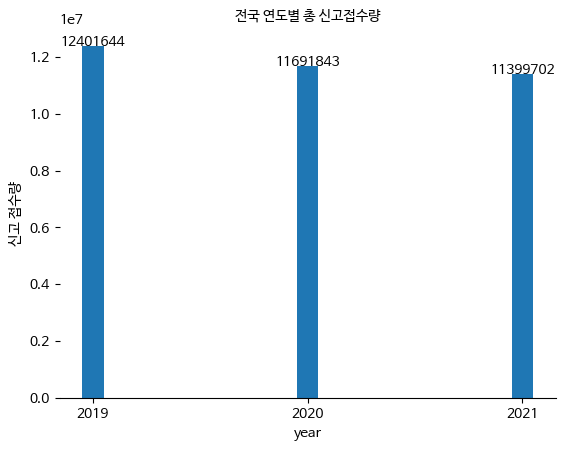

In [22]:
year_report = [arr['RPRT_CASCNT_WHOL'].sum() for arr in div_year]

plt.rc('font', family='NanumBarunGothic') 
plt.bar(year, [arr['RPRT_CASCNT_WHOL'].sum() for arr in div_year], 
        align='center', width = 0.1, linewidth=5, tick_label=year)

for i, v in enumerate(year):
  plt.text(v, year_report[i], year_report[i], horizontalalignment = 'center')

plt.rc('font', family='NanumBarunGothic') 
plt.title('전국 연도별 총 신고접수량', fontsize = 10)
plt.xlabel('year', fontsize = 10)
plt.ylabel('신고 접수량', fontsize = 10)

plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
plt.gca().spines['top'].set_visible(False) #위 테두리 제거
plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

# plt.plot(year, year_report, color='b',linestyle='--', marker='o') ## 선 그래프 출력

plt.show()

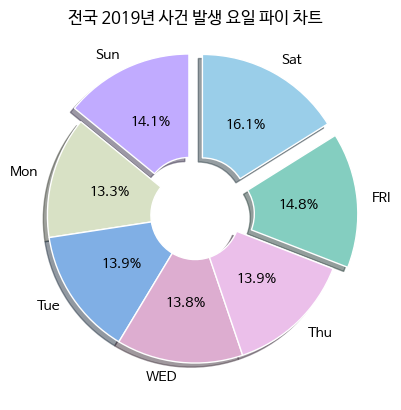

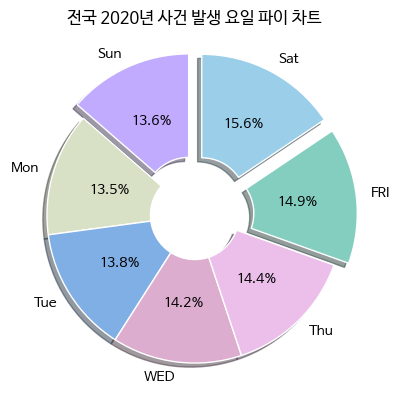

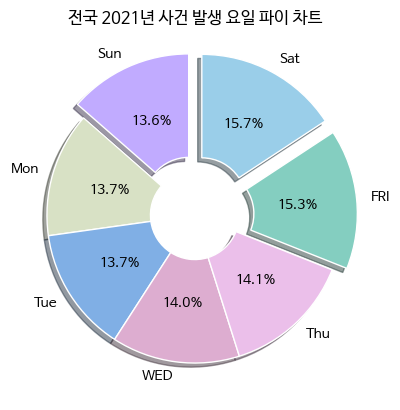

In [23]:
def draw_pieplot(year_df, year):
  colors = ['#c1abff', '#d8e1c5', '#80afe5', '#ddadd0', '#ebbfea', 
            '#84cec0', '#9acee9', '#d6c2b6', '#d48c9d', '#dcf6c5']
  ratio = [year_df[i].sum()/year_df['RPRT_CASCNT_WHOL'].sum() for i in week]
  labels = ['Sun', 'Mon', 'Tue', 'WED', 'Thu', 'FRI', 'Sat']
  explode = [0.1, 0, 0, 0, 0, 0.1,  0.1]
  wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}

  plt.title('전국 {0}년 사건 발생 요일 파이 차트'.format(year))
  plt.pie(ratio, labels = labels, autopct = '%.1f%%', startangle=90,
          colors=colors, explode = explode, shadow = True, wedgeprops=wedgeprops)

  plt.show()
  print('\n'*3)
  return

for j in range(3):
  draw_pieplot(div_year[j], year[j])
# plt.savefig('./images/my_pie_chart.png')

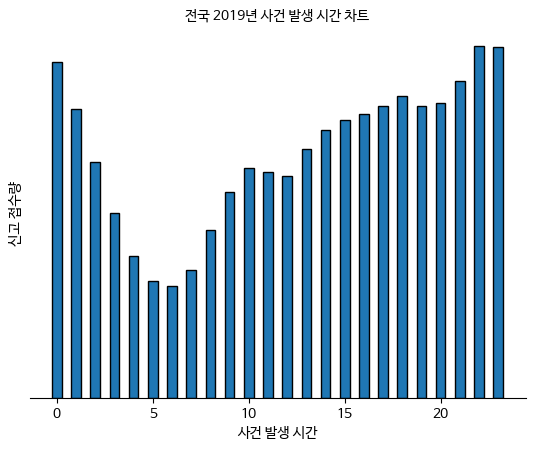

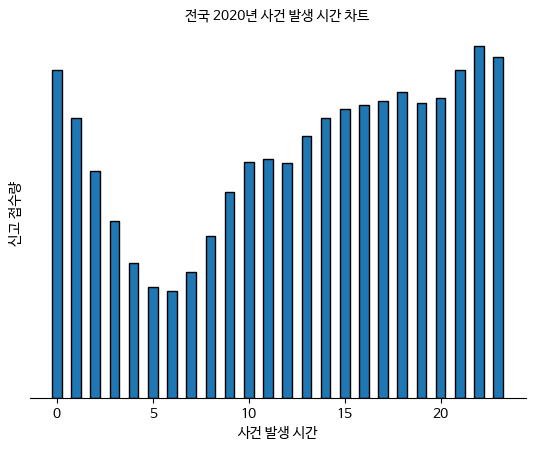

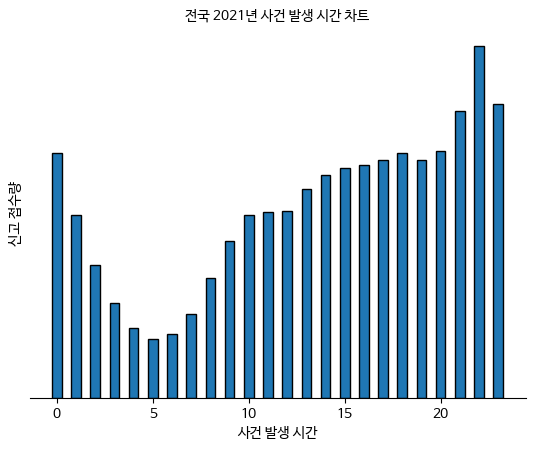

In [24]:
def draw_barplot(year_df, year):
  report_cnt = [year_df[x].sum() for x in hours]  
  plt.bar(time, report_cnt, width = 0.5, edgecolor='black')

  plt.title(f'전국 {year}년 사건 발생 시간 차트', fontsize = 10)
  plt.xlabel('사건 발생 시간', fontsize = 10)
  plt.ylabel('신고 접수량', fontsize = 10)
  plt.yticks(ticks= [])

  plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
  plt.gca().spines['top'].set_visible(False) #위 테두리 제거
  plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

  plt.show()
  print('\n'*3)
  return

for j in range(3):
  draw_barplot(div_year[j], year[j])

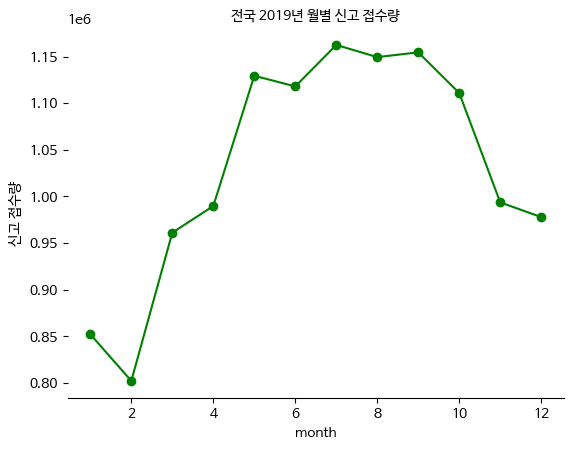

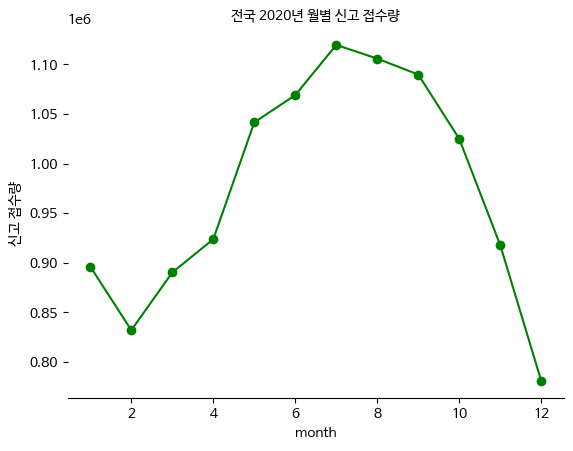

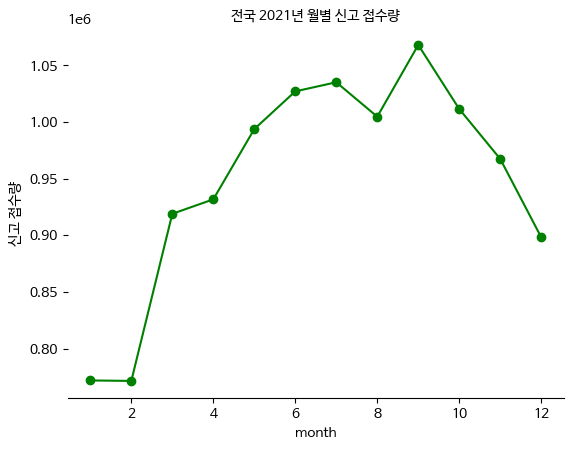

In [25]:
def draw_piplot(year_df, year):
  report_sum = [year_df[year_df['Month'] == x]['RPRT_CASCNT_WHOL'].sum() for x in month]

  plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
  plt.gca().spines['top'].set_visible(False) #위 테두리 제거
  plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

  plt.plot(month, report_sum, marker='o', color = 'g')
  plt.title(f'전국 {year}년 월별 신고 접수량', fontsize = 10)
  plt.xlabel('month', fontsize = 10)
  plt.ylabel('신고 접수량', fontsize = 10)
  plt.show()

  print('\n'*3)
  return


for j in range(3):
  draw_piplot(div_year[j], year[j])

### incheon

In [26]:
# 인천 경찰관서 필터링
incheon_df = df[df['PLCST_NM'].str.contains('인천')]

In [27]:
incheon_df.shape

(418, 52)

In [28]:
incheon_df.describe()

,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,...,OCRN_TIZN_23,CFINC_DSTVC,CFINC_DTVC,CFINC_MRDR,CFINC_SVLNC,CFINC_SUCD,CFINC_INCVLC,CFINC_ETC,Year,Month
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,5463.574163,2980.174641,1651.631579,829.928230,1.622010,62.935407,1037.492823,3333.913876,399.504785,629.727273,...,331.495215,129.483254,41.016746,0.234450,16.119617,49.007177,219.169856,5112.253589,2019.968900,6.497608
std,3275.465004,1844.523548,1016.036541,501.052197,2.287636,61.994338,837.002119,2143.308462,289.154148,382.753212,...,212.363035,89.272766,33.032390,0.551918,12.609047,29.318109,147.642570,3110.194722,0.811482,3.458038
min,67.000000,48.000000,14.000000,5.000000,0.000000,0.000000,2.000000,21.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000,2019.000000,1.000000
25%,3952.000000,2136.500000,1186.750000,551.500000,0.000000,24.000000,488.250000,2074.250000,176.250000,447.500000,...,199.250000,81.000000,17.250000,0.000000,5.000000,30.000000,125.750000,3613.000000,2019.000000,3.250000
50%,5557.000000,2969.000000,1669.500000,791.500000,0.000000,37.500000,802.000000,3347.000000,368.000000,627.500000,...,335.500000,130.000000,36.000000,0.000000,15.000000,46.500000,222.000000,5130.000000,2020.000000,6.500000
75%,6942.750000,3814.000000,2128.500000,1143.750000,3.000000,88.500000,1514.500000,4467.500000,564.000000,821.000000,...,461.750000,166.000000,60.500000,0.000000,23.000000,65.750000,312.750000,6595.250000,2021.000000,9.000000
max,13114.000000,7560.000000,4076.000000,2127.000000,10.000000,325.000000,4005.000000,9183.000000,1364.000000,2037.000000,...,873.000000,364.000000,167.000000,3.000000,67.000000,184.000000,776.000000,16546.000000,2021.000000,12.000000


In [29]:
incheon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 202 to 9801
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ACPT_YM                  418 non-null    datetime64[ns]
 1   PLCST_NM                 418 non-null    object        
 2   RPRT_CASCNT_WHOL         418 non-null    int64         
 3   RPRT_SEX_MALE            418 non-null    int64         
 4   RPRT_SEX_FMLE            418 non-null    int64         
 5   RPRT_SEX_UNKWN           418 non-null    int64         
 6   RPRT_SEX_ETC             418 non-null    int64         
 7   ACPT_EMERG_TYPE_EMERG    418 non-null    int64         
 8   ACPT_EMERG_TYPE_IMPRTNC  418 non-null    int64         
 9   ACPT_EMERG_TYPE_GNRL     418 non-null    int64         
 10  ACPT_EMERG_TYPE_CVAPP    418 non-null    int64         
 11  ACPT_EMERG_TYPE_ETC      418 non-null    int64         
 12  OCRN_DOTW_SNDD           418 non-

In [30]:
incheon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 202 to 9801
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ACPT_YM                  418 non-null    datetime64[ns]
 1   PLCST_NM                 418 non-null    object        
 2   RPRT_CASCNT_WHOL         418 non-null    int64         
 3   RPRT_SEX_MALE            418 non-null    int64         
 4   RPRT_SEX_FMLE            418 non-null    int64         
 5   RPRT_SEX_UNKWN           418 non-null    int64         
 6   RPRT_SEX_ETC             418 non-null    int64         
 7   ACPT_EMERG_TYPE_EMERG    418 non-null    int64         
 8   ACPT_EMERG_TYPE_IMPRTNC  418 non-null    int64         
 9   ACPT_EMERG_TYPE_GNRL     418 non-null    int64         
 10  ACPT_EMERG_TYPE_CVAPP    418 non-null    int64         
 11  ACPT_EMERG_TYPE_ETC      418 non-null    int64         
 12  OCRN_DOTW_SNDD           418 non-

In [31]:
# 인천 데이터 연도별 분리
df_19 = incheon_df[incheon_df['Year'] == 2019]
df_20 = incheon_df[incheon_df['Year'] == 2020]
df_21 = incheon_df[incheon_df['Year'] == 2021]

# 반복문 활용 시
div_year = [df_19, df_20, df_21]

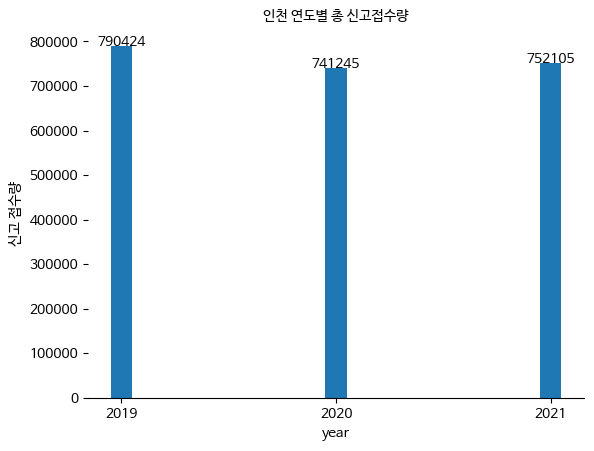

In [32]:
year_report = [arr['RPRT_CASCNT_WHOL'].sum() for arr in div_year]

plt.rc('font', family='NanumBarunGothic') 
plt.bar(year, [arr['RPRT_CASCNT_WHOL'].sum() for arr in div_year], 
        align='center', width = 0.1, linewidth=5, tick_label=year)

for i, v in enumerate(year):
  plt.text(v, year_report[i], year_report[i], horizontalalignment = 'center')

plt.rc('font', family='NanumBarunGothic') 
plt.title('인천 연도별 총 신고접수량', fontsize = 10)
plt.xlabel('year', fontsize = 10)
plt.ylabel('신고 접수량', fontsize = 10)

plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
plt.gca().spines['top'].set_visible(False) #위 테두리 제거
plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

# plt.plot(year, year_report, color='b',linestyle='--', marker='o') ## 선 그래프 출력

plt.show()

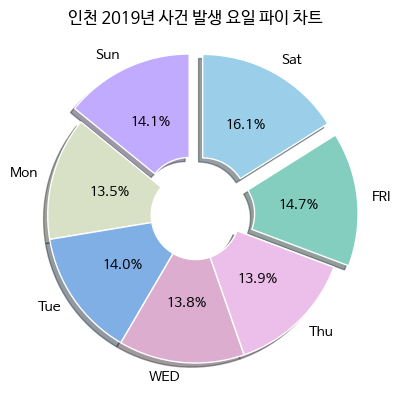

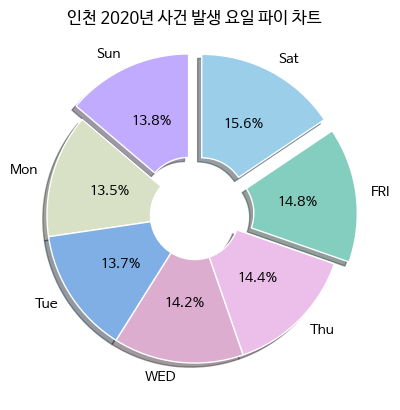

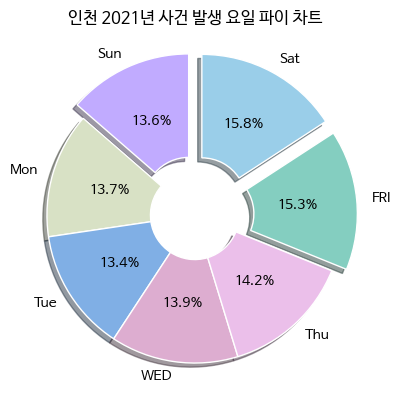

In [33]:
def draw_pieplot(year_df, year):
  colors = ['#c1abff', '#d8e1c5', '#80afe5', '#ddadd0', '#ebbfea', 
            '#84cec0', '#9acee9', '#d6c2b6', '#d48c9d', '#dcf6c5']
  ratio = [year_df[i].sum()/year_df['RPRT_CASCNT_WHOL'].sum() for i in week]
  labels = ['Sun', 'Mon', 'Tue', 'WED', 'Thu', 'FRI', 'Sat']
  explode = [0.1, 0, 0, 0, 0, 0.1,  0.1]
  wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}

  plt.title('인천 {0}년 사건 발생 요일 파이 차트'.format(year))
  plt.pie(ratio, labels = labels, autopct = '%.1f%%', startangle=90,
          colors=colors, explode = explode, shadow = True, wedgeprops=wedgeprops)

  plt.show()
  print('\n'*3)
  return

for j in range(3):
  draw_pieplot(div_year[j], year[j])
# plt.savefig('./images/my_pie_chart.png')

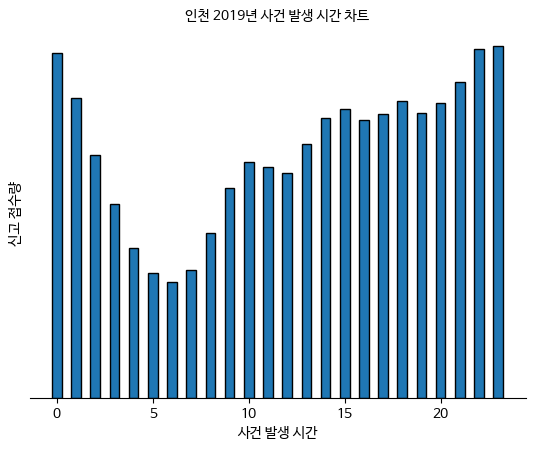

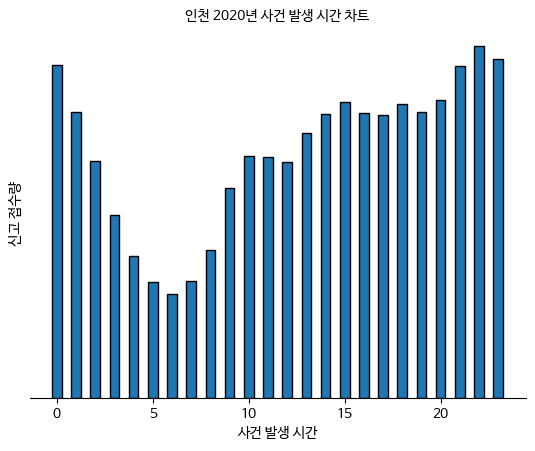

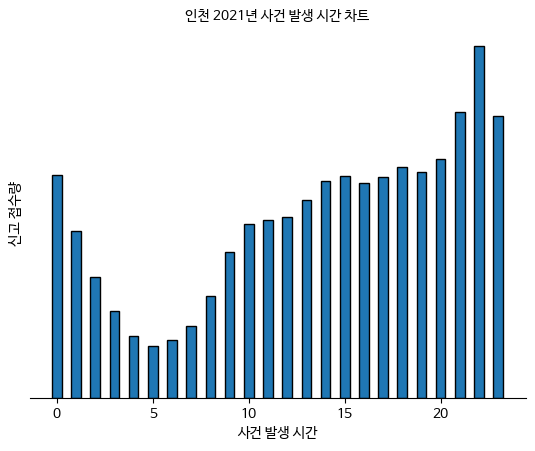

In [34]:
def draw_barplot(year_df, year):
  report_cnt = [year_df[x].sum() for x in hours]  
  plt.bar(time, report_cnt, width = 0.5, edgecolor='black')

  plt.title(f'인천 {year}년 사건 발생 시간 차트', fontsize = 10)
  plt.xlabel('사건 발생 시간', fontsize = 10)
  plt.ylabel('신고 접수량', fontsize = 10)
  plt.yticks(ticks= [])

  plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
  plt.gca().spines['top'].set_visible(False) #위 테두리 제거
  plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

  plt.show()
  print('\n'*3)
  return

for j in range(3):
  draw_barplot(div_year[j], year[j])

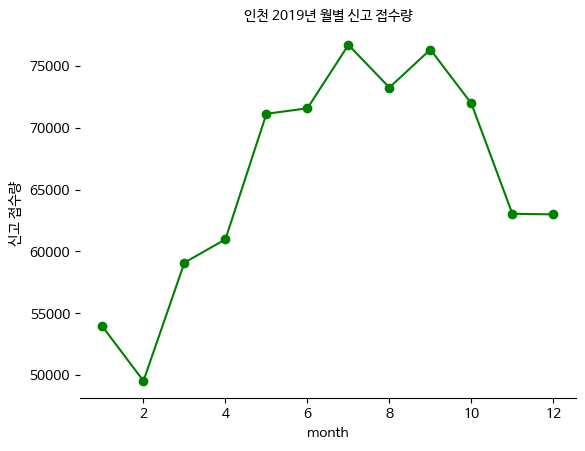

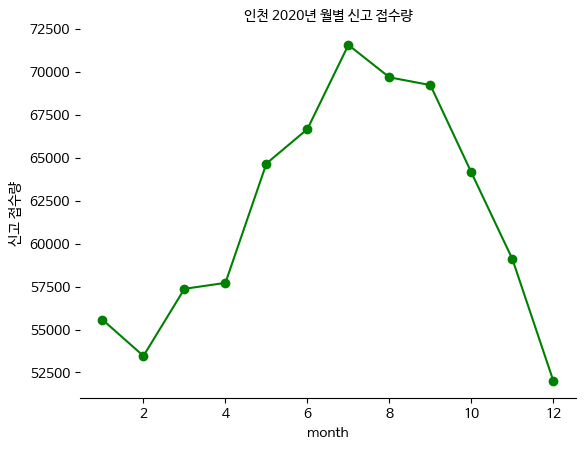

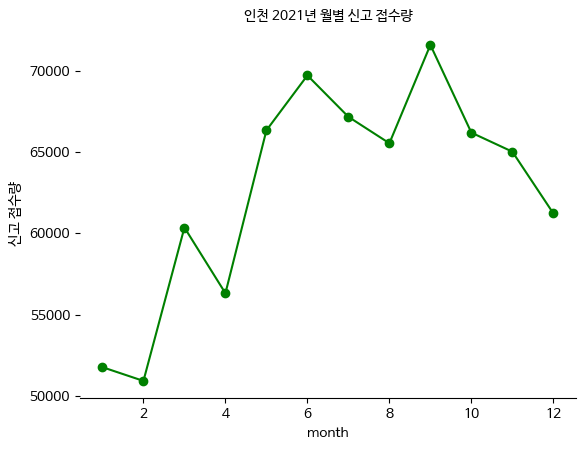

In [35]:
def draw_piplot(year_df, year):
  report_sum = [year_df[year_df['Month'] == x]['RPRT_CASCNT_WHOL'].sum() for x in month]

  plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
  plt.gca().spines['top'].set_visible(False) #위 테두리 제거
  plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

  plt.plot(month, report_sum, marker='o', color = 'g')
  plt.title(f'인천 {year}년 월별 신고 접수량', fontsize = 10)
  plt.xlabel('month', fontsize = 10)
  plt.ylabel('신고 접수량', fontsize = 10)
  plt.show()

  print('\n'*3)
  return


for j in range(3):
  draw_piplot(div_year[j], year[j])

### Incheon 시계열 분석

In [57]:
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime

%matplotlib inline

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

In [61]:
!pip install SCALECAST

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.7 MB/s eta 0:00:00
  Created wheel for SCALECAST: filename=SCALECAST-0.18.6-py3-none-any.whl size=111501 sha256=342f1bb28611830b104448c2e3ef7aae20c3edaf7e8d9401323b65f50ddae2a4
  Stored in directory: /root/.cache/pip/wheels/98/3e/ce/7dc7b94864270b53b482d4ed19d35b547dfa6d4369659516e5
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=1

In [62]:
from scalecast.Forecaster import Forecaster
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [89]:
total_incheon = incheon_df.groupby(['ACPT_YM'])['RPRT_CASCNT_WHOL'].agg(**{'report_cnt':'sum'}).reset_index()
total_incheon

,ACPT_YM,report_cnt
0,2019-01-01,53937
1,2019-02-01,49541
2,2019-03-01,59094
3,2019-04-01,60976
4,2019-05-01,71114
5,2019-06-01,71560
6,2019-07-01,76678
7,2019-08-01,73237
8,2019-09-01,76307
9,2019-10-01,71948


<Axes: xlabel='Date', ylabel='Values'>

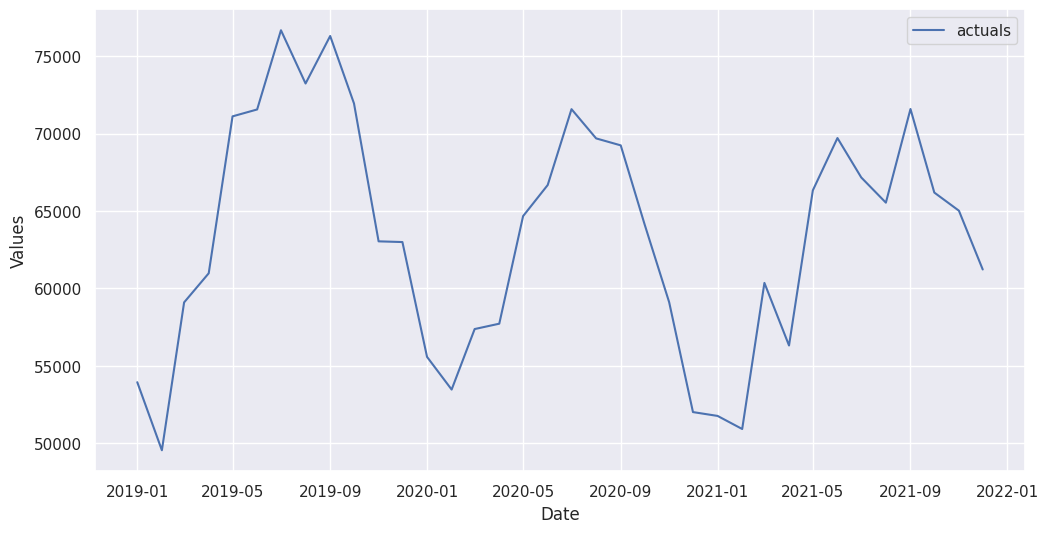

In [90]:
f = Forecaster(y=total_incheon['report_cnt'], current_dates=total_incheon['ACPT_YM'])
f.plot()

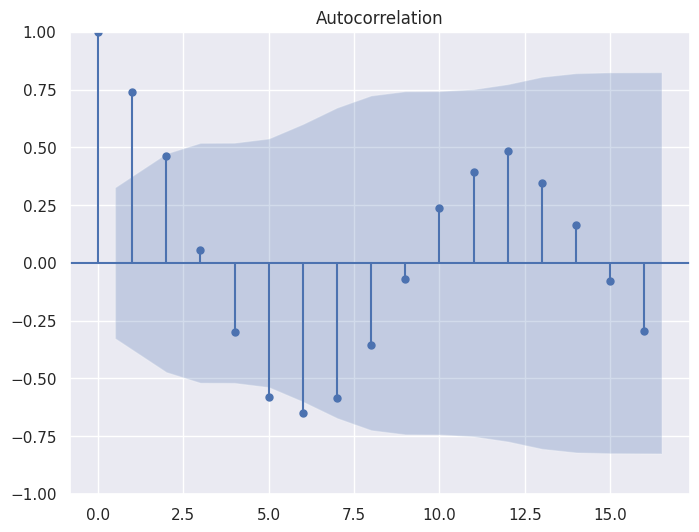

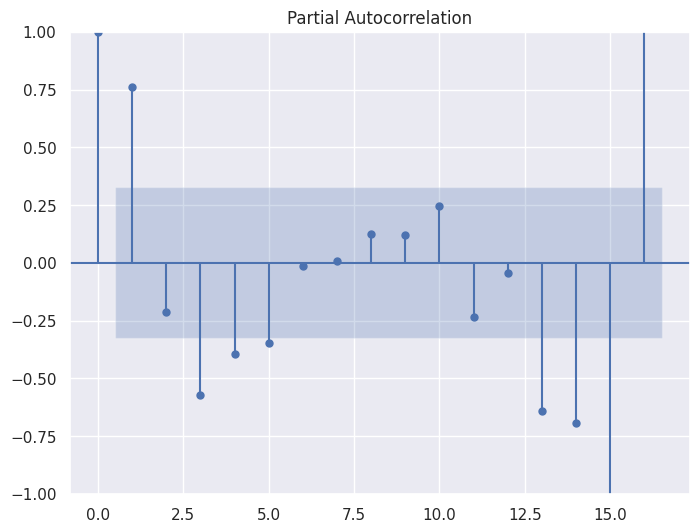

In [91]:
f.plot_acf()
f.plot_pacf()
plt.show()

In [92]:
import os 
import numpy as np 
import pandas as pd
from pandas import to_datetime
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
import warnings
import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

%matplotlib inline

# ARIMA 모델 패키지
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# Auto Arima 모델 패키지
# pip install --user pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [132]:
# train 데이터와 validation 데이터 나누기.
X_train = total_incheon[total_incheon['ACPT_YM'] < '2021-06']
X_valid = total_incheon[total_incheon['ACPT_YM'] >= '2021-07']

# 예측한 열만 필터링하기
nyc = X_train[['ACPT_YM', 'report_cnt']]
nyc_v = X_valid[['ACPT_YM', 'report_cnt']]

# 각 데이터의 사이즈 확인하기
print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

# Date 를 dataframe의 인덱스로 만들어주기
nyc.set_index('ACPT_YM', inplace=True)
nyc_v.set_index('ACPT_YM', inplace=True)

X_train Shape (29, 2)
X_Valid Shape (6, 2)


In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = SARIMAX(nyc,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
 

(0, 0, 0) 725.4021614946479
(0, 0, 1) 709.5268324175333
(0, 0, 2) 705.6624581588135
(0, 0, 3) 705.7762278906171
(0, 0, 4) 706.0676120308652
(0, 1, 0) 563.0907237122568
(0, 1, 1) 565.0270912111631
(0, 1, 2) 558.8523494671564
(0, 1, 3) 561.2016284766183
(0, 1, 4) 561.579275005239
(0, 2, 0) 560.5760667351236
(0, 2, 1) 548.7112235926583
(0, 2, 2) 548.9573103051367
(0, 2, 3) 558.501799652152
(0, 2, 4) 559.8469429126505
(0, 3, 0) 570.0056727849864
(0, 3, 1) 541.5763529760595
(0, 3, 2) 535.7846146142246
(0, 3, 3) 530.2282286252309
(0, 3, 4) 548.1947837867352
(0, 4, 0) 578.8043474193074
(0, 4, 1) 550.5062901905618
(0, 4, 2) 528.8314307143843
(0, 4, 3) 528.0160805916582
(0, 4, 4) 526.6470702180519
(1, 0, 0) 589.8791904986009
(1, 0, 1) 591.8958012621086
(1, 0, 2) 579.3834754567781
(1, 0, 3) 581.4851349677242
(1, 0, 4) 582.6387647561829
(1, 1, 0) 564.5893596755762
(1, 1, 1) 561.307503868529
(1, 1, 2) 560.148993393395
(1, 1, 3) 571.1964062688177
(1, 1, 4) 564.6524443893788
(1, 2, 0) 546.7740829567

ValueError: ignored

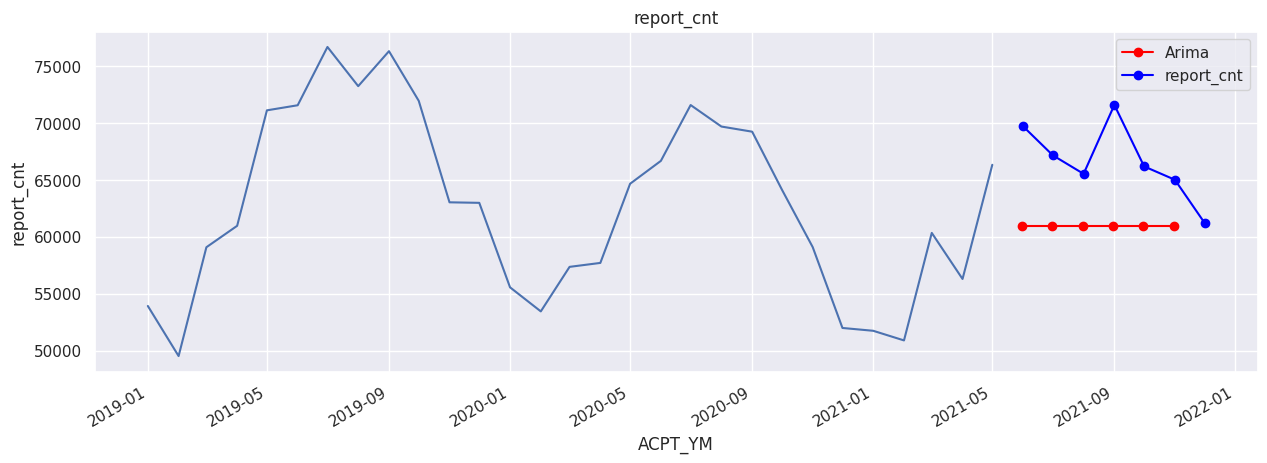

In [131]:
# 4주간의 값을 예측할 것이므로 예측날짜들을 인덱스로 한 dataframe 만들기
index_4_weeks = pd.date_range(nyc.index[-1], freq='M', periods = 6, tz = None) 


#본격 모델 돌리기..

#order= 뒤에 (p,d,q)의 값을 정해 넣어주면 된다. 

# order 에 파라미터 넣어주기.
model_arima = SARIMAX(nyc, order=(1,0,2)) 
model_arima_fit = model_arima.fit(disp=-1)

# 예측한 값들을 저장
fcast1 = model_arima_fit.forecast(6)[0]
fcast1 = pd.Series(fcast1, index=index_4_weeks)
fcast1 = fcast1.rename("Arima") 

# 예측값 plot 하기
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='ACPT_YM', y='report_cnt', data = nyc)
chart.set_title('report_cnt')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
nyc_v.plot(ax=ax, color='blue', marker="o", legend=True)

# AIC 프린트하기
print('The MSE of ARIMA is:', mean_squared_error(nyc_v['report_cnt'].values, fcast1.values, squared=False))

In [116]:
nyc_v

,report_cnt
ACPT_YM,
2021-04-01,56309
2021-05-01,66334
2021-06-01,69713
2021-07-01,67165
2021-08-01,65538
2021-09-01,71589
2021-10-01,66191
2021-11-01,65019
2021-12-01,61221


[56309 66334 69713 67165 65538 71589 66191 65019 61221]
[nan nan nan nan nan nan nan nan nan]


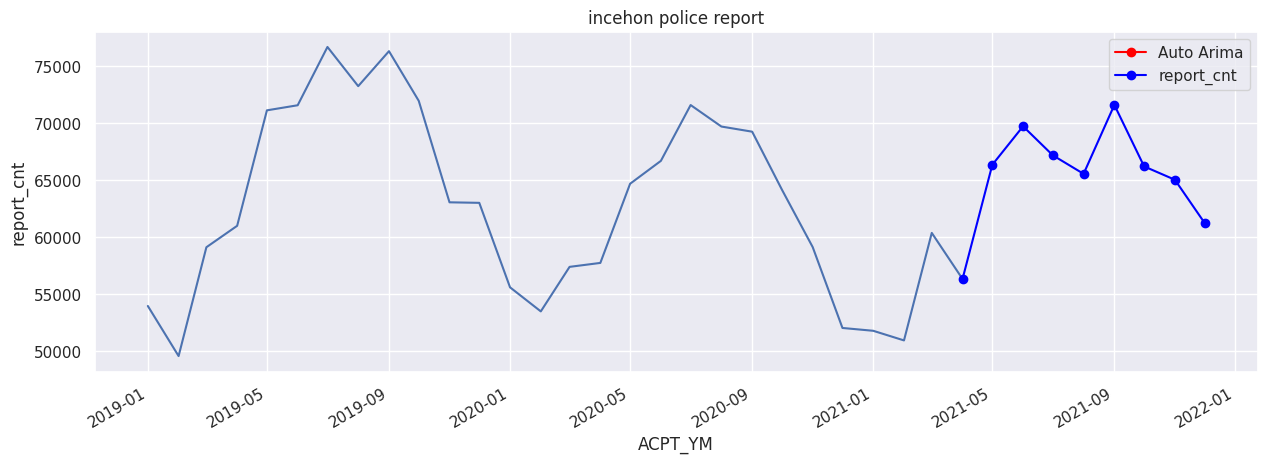

In [119]:
# Auto-ARIMA 돌리기 - 계측값이 일별이면 m=1, 월별이면 m=12, 주별이면 m=52, 
# 계절성이 있는 데이터면 seasonal=True 로 바꿔야함. 알아서 d 값을 찾아줌.
auto_arima_model = pm.auto_arima(nyc, seasonal=False, m=12)

# 모델 예측
fcast2 = auto_arima_model.predict(9) 
fcast2 = pd.Series(fcast2, index=index_4_weeks)
fcast2 = fcast2.rename("Auto Arima")

# 예측값 시각화
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='ACPT_YM', y='report_cnt', data = nyc)
chart.set_title('incehon police report')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
nyc_v.plot(ax=ax, color='blue', marker="o", legend=True)
print(nyc_v['report_cnt'].values)
print(fcast2.values)
# # AIC 프린트하기
# print('The MSE of auto-arima is:', mean_squared_error(nyc_v['report_cnt'].values, fcast2.values, squared=False))

In [120]:
fcast2

2021-04-04   NaN
2021-04-11   NaN
2021-04-18   NaN
2021-04-25   NaN
2021-05-02   NaN
2021-05-09   NaN
2021-05-16   NaN
2021-05-23   NaN
2021-05-30   NaN
Freq: W-SUN, Name: Auto Arima, dtype: float64

In [51]:
total_inccheon = incheon_df.groupby(['ACPT_YM'])['RPRT_CASCNT_WHOL'].agg(**{'report_cnt':'sum'})

In [55]:
total_inccheon.head()

,report_cnt
ACPT_YM,
2019-01-01,53937
2019-02-01,49541
2019-03-01,59094
2019-04-01,60976
2019-05-01,71114


In [52]:
total_inccheon.shape

(36, 1)

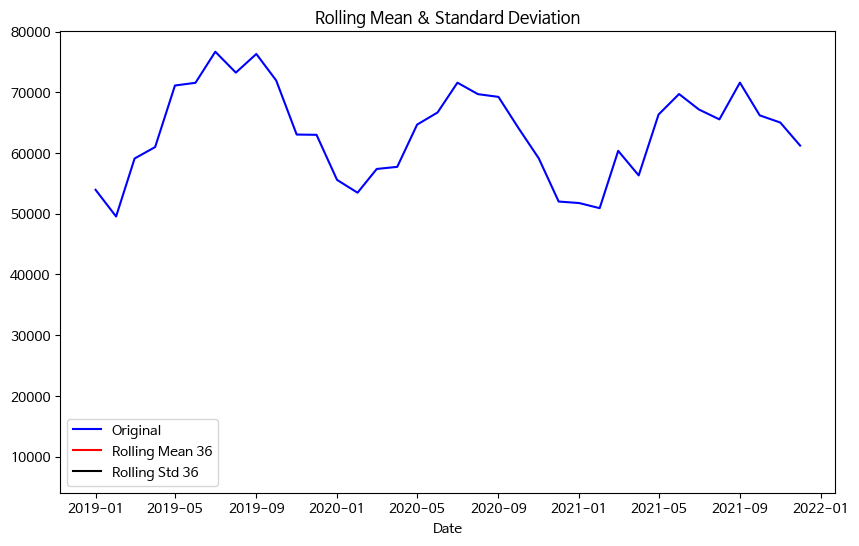

In [53]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
  
plot_rolling(total_inccheon, 36)

In [54]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST 결과')
adf_test(total_inccheon)

ADF TEST 결과
ADF Statistics: -5.049154
p-value: 0.000018
num of lags: 4.000000
num of observations: 31.000000
Critical values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


### Seoul

In [36]:
# 서울 경찰관서 필터링
seoul_df = df[df['PLCST_NM'].str.contains('서울')]

In [37]:
seoul_df.describe()

,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,...,OCRN_TIZN_23,CFINC_DSTVC,CFINC_DTVC,CFINC_MRDR,CFINC_SVLNC,CFINC_SUCD,CFINC_INCVLC,CFINC_ETC,Year,Month
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,...,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,6602.579861,3594.623264,1912.990451,1093.818576,0.995660,59.900174,1466.839410,3739.020833,526.153646,810.665799,...,440.003472,105.232639,25.175347,0.286458,20.013889,54.852431,259.783854,6262.325521,2020.000000,6.500000
std,2970.160333,1641.392662,875.493120,572.364557,1.482296,33.361713,665.179531,1713.326051,271.686114,429.641178,...,218.643973,63.097126,19.435620,0.697189,14.330946,30.087317,140.465050,2888.716349,0.816851,3.453552
min,524.000000,306.000000,152.000000,33.000000,0.000000,3.000000,332.000000,82.000000,7.000000,0.000000,...,26.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,481.000000,2019.000000,1.000000
25%,4052.000000,2196.000000,1179.750000,661.500000,0.000000,34.000000,855.250000,2374.250000,318.000000,485.750000,...,266.000000,62.000000,11.000000,0.000000,9.000000,33.000000,152.000000,3828.750000,2019.000000,3.750000
50%,6644.500000,3561.000000,1927.500000,1011.500000,0.000000,55.000000,1481.000000,3697.500000,506.000000,790.000000,...,427.500000,101.500000,21.000000,0.000000,17.000000,50.500000,238.500000,6206.000000,2020.000000,6.500000
75%,8718.750000,4715.000000,2506.000000,1459.000000,2.000000,80.000000,1919.000000,4869.500000,687.250000,1050.000000,...,576.250000,142.000000,35.000000,0.000000,28.000000,73.000000,353.000000,8242.250000,2021.000000,9.250000
max,14862.000000,8323.000000,4552.000000,3259.000000,12.000000,233.000000,3399.000000,8621.000000,1478.000000,2732.000000,...,1149.000000,312.000000,141.000000,8.000000,92.000000,206.000000,892.000000,17908.000000,2021.000000,12.000000


In [38]:
# 서울 데이터 연도별 분리
df_19 = seoul_df[seoul_df['Year'] == 2019]
df_20 = seoul_df[seoul_df['Year'] == 2020]
df_21 = seoul_df[seoul_df['Year'] == 2021]

# 반복문 활용 시
div_year = [df_19, df_20, df_21]

### Bucheon